# Starbucks Popularity Prediction (Project)
Background: Starbucks operates in a highly competitive beverage market where product success depends on understanding consumer preferences early. Online platforms like Reddit and Yelp capture large volumes of user-generated opinions, but most of this information is unstructured and underused in decision-making. This project aims to convert those discussions and reviews into measurable signals, then use them to predict relative product popularity. The final goal is to support marketing prioritization by identifying which beverages are most likely to succeed based on early online attention and sentiment.


In [2]:
import re
import pandas as pd
from pathlib import Path

# 1) read csv
DATA_PATH = Path("starbucks.csv")
df = pd.read_csv(DATA_PATH)

# 2) clean col name
def clean_column_name(col: str) -> str:
    col = col.strip()
    col = col.replace("%", "pct")
    col = re.sub(r"\([^)]*\)", "", col)
    col = re.sub(r"[^A-Za-z0-9]+", "_", col)
    col = re.sub(r"_+", "_", col)
    return col.strip("_").lower()

df.columns = [clean_column_name(c) for c in df.columns]

# 3) data cleaning
id_cols = {"beverage_category", "beverage", "beverage_prep"}
num_cols = [c for c in df.columns if c not in id_cols]

for c in num_cols:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.replace("%", "", regex=False).str.strip()
    df[c] = pd.to_numeric(df[c], errors="coerce")

df.head()

,beverage_category,beverage,beverage_prep,calories,total_fat,trans_fat,saturated_fat,sodium,total_carbohydrates,cholesterol,dietary_fibre,sugars,protein,vitamin_a,vitamin_c,calcium,iron,caffeine
0,Coffee,Brewed Coffee,Short,3,0.1,0.0,0.0,0,5,0,0,0,0.3,0,0,0,0.0,175.0
1,Coffee,Brewed Coffee,Tall,4,0.1,0.0,0.0,0,10,0,0,0,0.5,0,0,0,0.0,260.0
2,Coffee,Brewed Coffee,Grande,5,0.1,0.0,0.0,0,10,0,0,0,1.0,0,0,0,0.0,330.0
3,Coffee,Brewed Coffee,Venti,5,0.1,0.0,0.0,0,10,0,0,0,1.0,0,0,2,0.0,410.0
4,Classic Espresso Drinks,Caffè Latte,Short Nonfat Milk,70,0.1,0.1,0.0,5,75,10,0,9,6.0,10,0,20,0.0,75.0


In [4]:
# Shape and basic info
print("Shape:", df.shape)
print(df.dtypes)

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Missing values:\n", missing if not missing.empty else "No missing values")

# Duplicates
dup_rows = df.duplicated().sum()
print("Duplicate rows:", dup_rows)

# Unique counts
print("Unique beverages:", df["beverage"].nunique())
print("Unique beverage_prep:", df["beverage_prep"].nunique())

Shape: (242, 18)
beverage_category       object
beverage                object
beverage_prep           object
calories                 int64
total_fat              float64
trans_fat              float64
saturated_fat          float64
sodium                   int64
total_carbohydrates      int64
cholesterol              int64
dietary_fibre            int64
sugars                   int64
protein                float64
vitamin_a                int64
vitamin_c                int64
calcium                  int64
iron                   float64
caffeine               float64
dtype: object
Missing values:
 caffeine     23
total_fat     1
dtype: int64
Duplicate rows: 0
Unique beverages: 33
Unique beverage_prep: 13


In [6]:
# Show rows with missing caffeine or total_fat
missing_rows = df[df["caffeine"].isna() | df["total_fat"].isna()]
missing_rows[["beverage_category", "beverage", "beverage_prep", "caffeine", "total_fat"]]

,beverage_category,beverage,beverage_prep,caffeine,total_fat
102,Tazo® Tea Drinks,Tazo® Tea,Short,NaN,0.0
103,Tazo® Tea Drinks,Tazo® Tea,Tall,NaN,0.0
104,Tazo® Tea Drinks,Tazo® Tea,Grande,NaN,0.0
105,Tazo® Tea Drinks,Tazo® Tea,Venti,NaN,0.0
130,Tazo® Tea Drinks,Tazo® Full-Leaf Tea Latte,Short Nonfat Milk,NaN,0.1
131,Tazo® Tea Drinks,Tazo® Full-Leaf Tea Latte,2% Milk,NaN,2.0
132,Tazo® Tea Drinks,Tazo® Full-Leaf Tea Latte,Soymilk,NaN,1.5
133,Tazo® Tea Drinks,Tazo® Full-Leaf Tea Latte,Tall Nonfat Milk,NaN,0.1
134,Tazo® Tea Drinks,Tazo® Full-Leaf Tea Latte,2% Milk,NaN,3.0
135,Tazo® Tea Drinks,Tazo® Full-Leaf Tea Latte,Soymilk,NaN,2.5


In [7]:
# Impute missing values using category/ beverage medians

# Caffeine: category median -> fallback to overall median
df["caffeine"] = df.groupby("beverage_category")["caffeine"].transform(
    lambda s: s.fillna(s.median())
)
df["caffeine"] = df["caffeine"].fillna(df["caffeine"].median())

# Total fat: beverage median -> fallback to overall median
df["total_fat"] = df.groupby("beverage")["total_fat"].transform(
    lambda s: s.fillna(s.median())
)
df["total_fat"] = df["total_fat"].fillna(df["total_fat"].median())

# Quick check
df.isna().sum()[["caffeine", "total_fat"]]

,0
caffeine,0
total_fat,0


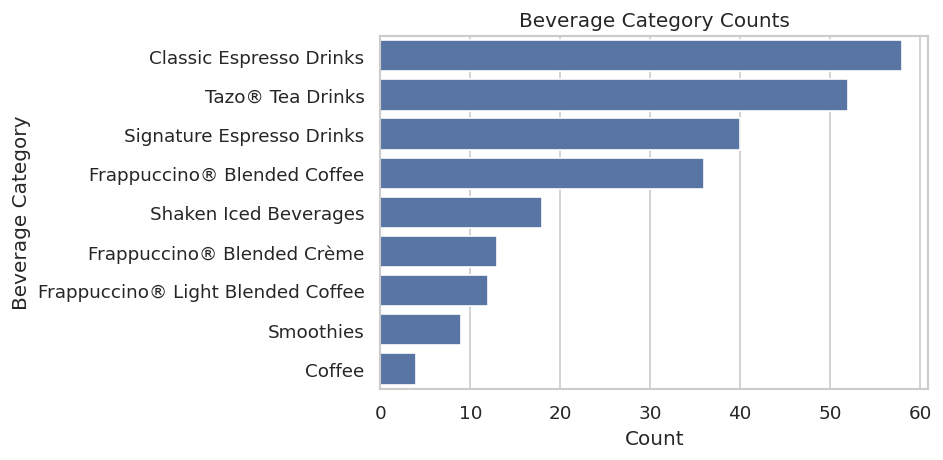

In [8]:
# Plot beverage category counts
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

plt.figure(figsize=(8,4))
order = df["beverage_category"].value_counts().index
sns.countplot(data=df, y="beverage_category", order=order, color="#4c72b0")
plt.title("Beverage Category Counts")
plt.xlabel("Count")
plt.ylabel("Beverage Category")
plt.tight_layout()
plt.show()

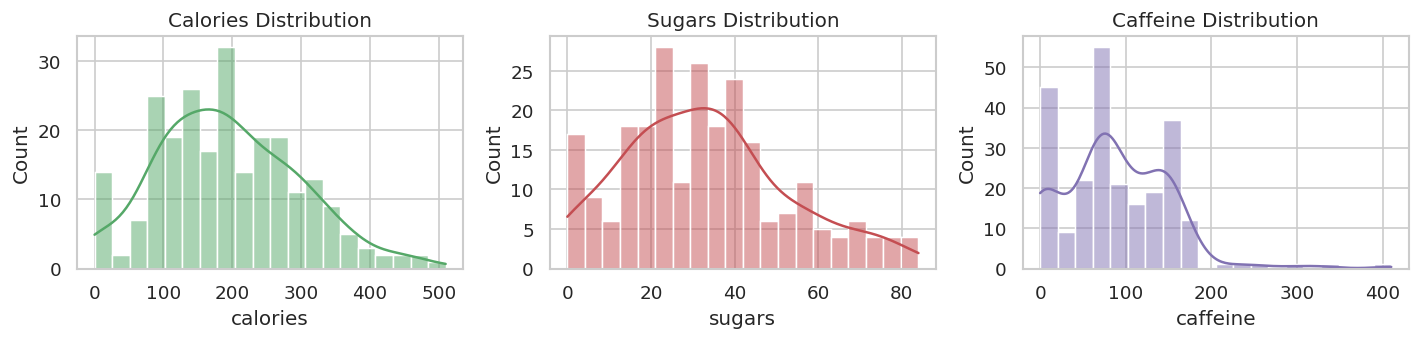

In [9]:
# Plot distributions for key numeric variables
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.histplot(df["calories"], bins=20, kde=True, ax=axes[0], color="#55a868")
axes[0].set_title("Calories Distribution")

sns.histplot(df["sugars"], bins=20, kde=True, ax=axes[1], color="#c44e52")
axes[1].set_title("Sugars Distribution")

sns.histplot(df["caffeine"], bins=20, kde=True, ax=axes[2], color="#8172b2")
axes[2].set_title("Caffeine Distribution")

plt.tight_layout()
plt.show()

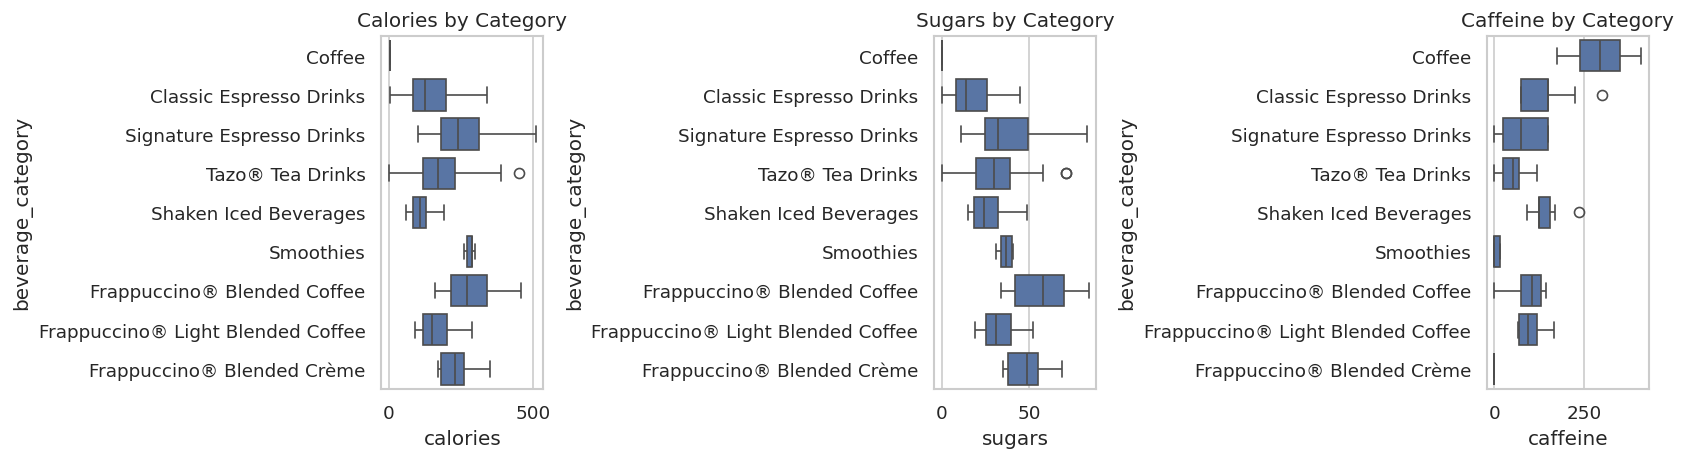

In [10]:
# Boxplots by beverage category
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(data=df, y="beverage_category", x="calories", ax=axes[0])
axes[0].set_title("Calories by Category")

sns.boxplot(data=df, y="beverage_category", x="sugars", ax=axes[1])
axes[1].set_title("Sugars by Category")

sns.boxplot(data=df, y="beverage_category", x="caffeine", ax=axes[2])
axes[2].set_title("Caffeine by Category")

plt.tight_layout()
plt.show()

In [24]:
# Load filtered Yelp data (5 cities)
business_path = "/content/businesses_starbucks_5cities.csv"
reviews_path = "/content/reviews_starbucks_5cities.csv"

biz = pd.read_csv(business_path)
rev = pd.read_csv(reviews_path)

print("Businesses:", biz.shape)
print("Reviews:", rev.shape)
print("Business columns:", biz.columns.tolist())
print("Review columns:", rev.columns.tolist())

biz.head()

Businesses: (249, 10)
Reviews: (6915, 9)
Business columns: ['business_id', 'name', 'city', 'state', 'postal_code', 'stars', 'review_count', 'categories', 'latitude', 'longitude']
Review columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']


,business_id,name,city,state,postal_code,stars,review_count,categories,latitude,longitude
0,6_Zf2QsRHCH1RhbzA9inyw,Starbucks,Tampa,FL,33615,3.0,56,"Coffee & Tea, Food",27.996370,-82.580954
1,Iipfa9Kaac9XH5Vo8GQwvg,Starbucks,Edmonton,AB,T5Y 2W1,3.5,10,"Coffee & Tea, Food",53.616147,-113.432424
2,sD2yBIzp0SNYRMD4QfH9Jw,Starbucks,Philadelphia,PA,19123,2.5,13,"Food, Coffee & Tea",39.966510,-75.140377
3,J7TZeIXaJFgrSIZzAjQMsw,Starbucks,Tucson,AZ,85704,3.5,6,"Coffee & Tea, Food",32.296291,-110.973648
4,OTBWyXkNsBYHqIlXJXnEDA,Starbucks,Philadelphia,PA,19102,3.0,39,"Food, Coffee & Tea",39.949485,-75.167352


In [25]:
# Build Yelp review-based features at business level
import pandas as pd

# Basic text length
rev["text_len"] = rev["text"].fillna("").str.len()

# Aggregate review-level signals per business
yelp_review_agg = rev.groupby("business_id").agg(
    review_count_reviews=("review_id", "count"),
    avg_stars_reviews=("stars", "mean"),
    avg_useful=("useful", "mean"),
    avg_funny=("funny", "mean"),
    avg_cool=("cool", "mean"),
    avg_text_len=("text_len", "mean"),
    first_review_date=("date", "min"),
    last_review_date=("date", "max"),
).reset_index()

# Merge with business metadata
yelp_features = biz.merge(yelp_review_agg, on="business_id", how="left")

print("Yelp features shape:", yelp_features.shape)
yelp_features.head()

Yelp features shape: (249, 18)


,business_id,name,city,state,postal_code,stars,review_count,categories,latitude,longitude,review_count_reviews,avg_stars_reviews,avg_useful,avg_funny,avg_cool,avg_text_len,first_review_date,last_review_date
0,6_Zf2QsRHCH1RhbzA9inyw,Starbucks,Tampa,FL,33615,3.0,56,"Coffee & Tea, Food",27.996370,-82.580954,58,2.965517,0.913793,0.465517,0.551724,494.913793,2011-09-03 18:32:37,2021-11-16 20:09:31
1,Iipfa9Kaac9XH5Vo8GQwvg,Starbucks,Edmonton,AB,T5Y 2W1,3.5,10,"Coffee & Tea, Food",53.616147,-113.432424,10,3.500000,0.200000,0.100000,0.000000,459.400000,2010-08-10 20:24:58,2018-04-05 05:25:43
2,sD2yBIzp0SNYRMD4QfH9Jw,Starbucks,Philadelphia,PA,19123,2.5,13,"Food, Coffee & Tea",39.966510,-75.140377,13,2.461538,0.846154,0.615385,0.461538,440.307692,2019-04-08 23:25:22,2021-12-09 15:57:55
3,J7TZeIXaJFgrSIZzAjQMsw,Starbucks,Tucson,AZ,85704,3.5,6,"Coffee & Tea, Food",32.296291,-110.973648,6,3.500000,0.333333,0.166667,0.166667,480.666667,2019-12-04 20:43:49,2021-12-05 16:37:54
4,OTBWyXkNsBYHqIlXJXnEDA,Starbucks,Philadelphia,PA,19102,3.0,39,"Food, Coffee & Tea",39.949485,-75.167352,40,3.225000,0.325000,0.300000,0.400000,509.425000,2010-01-21 02:57:54,2021-11-09 03:34:34


In [26]:
# Build popularity label (composite score)
import numpy as np

# Use review_count from business + avg_stars from reviews
yelp = yelp_features.copy()

# Standardize
yelp["review_count_z"] = (yelp["review_count"] - yelp["review_count"].mean()) / yelp["review_count"].std()
yelp["avg_stars_z"] = (yelp["avg_stars_reviews"] - yelp["avg_stars_reviews"].mean()) / yelp["avg_stars_reviews"].std()

# Composite score (weights can be adjusted)
yelp["popularity_score"] = 0.7 * yelp["review_count_z"] + 0.3 * yelp["avg_stars_z"]

# Binary label: top 25%
threshold = yelp["popularity_score"].quantile(0.75)
yelp["popular"] = (yelp["popularity_score"] >= threshold).astype(int)

yelp[["business_id", "city", "review_count", "avg_stars_reviews", "popularity_score", "popular"]].head()


,business_id,city,review_count,avg_stars_reviews,popularity_score,popular
0,6_Zf2QsRHCH1RhbzA9inyw,Tampa,56,2.965517,0.875937,1
1,Iipfa9Kaac9XH5Vo8GQwvg,Edmonton,10,3.500000,-0.397800,0
2,sD2yBIzp0SNYRMD4QfH9Jw,Philadelphia,13,2.461538,-0.770096,0
3,J7TZeIXaJFgrSIZzAjQMsw,Tucson,6,3.500000,-0.529647,0
4,OTBWyXkNsBYHqIlXJXnEDA,Philadelphia,39,3.225000,0.433320,0


In [39]:
import re

# Lowercase text for matching
text = rev["text"].fillna("").astype(str).str.lower()

# Expanded family keywords
product_families = {
    "latte": ["latte", "lattes", "iced latte", "caffe latte"],
    "mocha": ["mocha", "mochas"],
    "americano": ["americano", "americanos"],
    "cappuccino": ["cappuccino", "cappuccinos"],
    "macchiato": ["macchiato", "macchiatos"],
    "espresso": ["espresso", "espressos"],
    "frappuccino": ["frappuccino", "frappucino", "frap", "frappe", "frappé"],
    "chai": ["chai", "chai latte"],
    "matcha": ["matcha", "matcha latte"],
    "tea": ["tea", "iced tea", "green tea", "black tea"],
    "coffee": ["coffee", "iced coffee", "cold brew", "coldbrew", "brew", "brewed", "drip coffee", "black coffee", "decaf"],
}

def build_pattern(kws):
    parts = []
    for kw in kws:
        if " " in kw:
            parts.append(re.escape(kw))
        else:
            parts.append(r"\b" + re.escape(kw) + r"\b")
    return "(" + "|".join(parts) + ")"

# Create boolean flags per family
for fam, kws in product_families.items():
    pattern = build_pattern(kws)
    rev[f"fam_{fam}"] = text.str.contains(pattern, regex=True)

# Coverage and counts
fam_cols = [c for c in rev.columns if c.startswith("fam_")]
rev["family_count"] = rev[fam_cols].sum(axis=1)

print("Reviews with >=1 family:", (rev["family_count"] > 0).sum())
print("Coverage:", (rev["family_count"] > 0).mean())

family_counts = rev[fam_cols].sum().sort_values(ascending=False)
family_counts

/tmp/ipython-input-1200039511.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rev[f"fam_{fam}"] = text.str.contains(pattern, regex=True)


Reviews with >=1 family: 3110
Coverage: 0.4497469269703543


,0
fam_coffee,2294
fam_latte,441
fam_tea,431
fam_frappuccino,205
fam_mocha,191
fam_espresso,172
fam_chai,105
fam_macchiato,99
fam_americano,77
fam_matcha,28


In [40]:
import pandas as pd
import numpy as np

# Ensure date is datetime
rev["date"] = pd.to_datetime(rev["date"], errors="coerce")

# Ensure text length exists
if "text_len" not in rev.columns:
    rev["text_len"] = rev["text"].fillna("").str.len()

# Build long format for family mentions
fam_cols = [c for c in rev.columns if c.startswith("fam_")]
id_cols = ["review_id", "business_id", "stars", "useful", "funny", "cool", "text_len", "date"]

rev_long = rev[id_cols + fam_cols].melt(
    id_vars=id_cols, value_vars=fam_cols,
    var_name="family", value_name="mentioned"
)
rev_long = rev_long[rev_long["mentioned"]].copy()
rev_long["family"] = rev_long["family"].str.replace("fam_", "", regex=False)

# Aggregate to family-level stats
family_stats = rev_long.groupby("family").agg(
    mention_count=("review_id", "count"),
    unique_businesses=("business_id", "nunique"),
    avg_stars=("stars", "mean"),
    avg_useful=("useful", "mean"),
    avg_funny=("funny", "mean"),
    avg_cool=("cool", "mean"),
    avg_text_len=("text_len", "mean"),
    first_review_date=("date", "min"),
    last_review_date=("date", "max"),
).reset_index()

# Build popularity score with z-score
family_stats["mention_count_z"] = (
    (family_stats["mention_count"] - family_stats["mention_count"].mean())
    / family_stats["mention_count"].std()
)
family_stats["avg_stars_z"] = (
    (family_stats["avg_stars"] - family_stats["avg_stars"].mean())
    / family_stats["avg_stars"].std()
)

family_stats["popularity_score"] = 0.7 * family_stats["mention_count_z"] + 0.3 * family_stats["avg_stars_z"]

# Binary label: top 25%
threshold = family_stats["popularity_score"].quantile(0.75)
family_stats["popular"] = (family_stats["popularity_score"] >= threshold).astype(int)

family_stats.sort_values("popularity_score", ascending=False)

,family,mention_count,unique_businesses,avg_stars,avg_useful,avg_funny,avg_cool,avg_text_len,first_review_date,last_review_date,mention_count_z,avg_stars_z,popularity_score,popular
3,coffee,2294,244,3.090671,0.933740,0.406713,0.538797,580.477768,2007-02-13 20:16:54,2022-01-16 17:57:47,2.943183,0.389981,2.177223,1
10,tea,431,173,3.085847,1.020882,0.399072,0.617169,653.691415,2007-02-13 20:16:54,2022-01-16 18:24:05,0.093448,0.376576,0.178386,1
6,latte,441,174,3.011338,1.113379,0.521542,0.650794,634.315193,2007-12-15 16:11:56,2022-01-15 19:57:45,0.108744,0.169542,0.126983,1
2,chai,105,76,3.390476,1.238095,0.495238,0.857143,628.980952,2007-08-08 13:33:43,2022-01-15 19:57:45,-0.405218,1.223034,0.083258,0
9,mocha,191,117,3.261780,1.481675,0.706806,1.146597,675.921466,2008-08-12 14:09:47,2022-01-08 18:49:38,-0.273668,0.865433,0.068062,0
5,frappuccino,205,123,3.195122,0.878049,0.341463,0.609756,589.839024,2008-08-12 14:09:47,2022-01-09 01:14:21,-0.252253,0.680213,0.027487,0
4,espresso,172,107,3.069767,1.808140,0.651163,0.860465,712.343023,2007-12-15 14:59:08,2022-01-15 15:11:20,-0.302731,0.331897,-0.112343,0
7,macchiato,99,76,3.080808,1.171717,0.373737,0.787879,621.161616,2012-08-04 22:57:57,2021-12-13 19:06:42,-0.414396,0.362575,-0.181305,0
8,matcha,28,25,2.571429,0.785714,0.285714,0.428571,714.714286,2016-03-21 00:51:12,2022-01-16 18:24:05,-0.523001,-1.052812,-0.681944,0
1,cappuccino,26,22,2.384615,0.846154,0.384615,0.538462,566.192308,2008-10-30 04:25:36,2022-01-08 23:18:08,-0.526060,-1.571900,-0.839812,0


In [41]:
# Yelp EDA: basic summaries
print("Businesses:", biz.shape)
print("Reviews:", rev.shape)

print("\nBusiness stars summary:")
print(biz["stars"].describe())

print("\nBusiness review_count summary:")
print(biz["review_count"].describe())

print("\nReview stars summary:")
print(rev["stars"].describe())

print("\nReview text length summary:")
print(rev["text"].fillna("").str.len().describe())

Businesses: (249, 10)
Reviews: (6915, 24)

Business stars summary:
count    249.000000
mean       3.186747
std        0.672220
min        1.500000
25%        2.500000
50%        3.500000
75%        3.500000
max        5.000000
Name: stars, dtype: float64

Business review_count summary:
count    249.000000
mean      26.578313
std       21.236639
min        5.000000
25%        9.000000
50%       20.000000
75%       38.000000
max      124.000000
Name: review_count, dtype: float64

Review stars summary:
count    6915.000000
mean        3.189732
std         1.536984
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: stars, dtype: float64

Review text length summary:
count    6915.000000
mean      452.009400
std       379.610013
min        11.000000
25%       206.000000
50%       346.000000
75%       573.500000
max      4061.000000
Name: text, dtype: float64


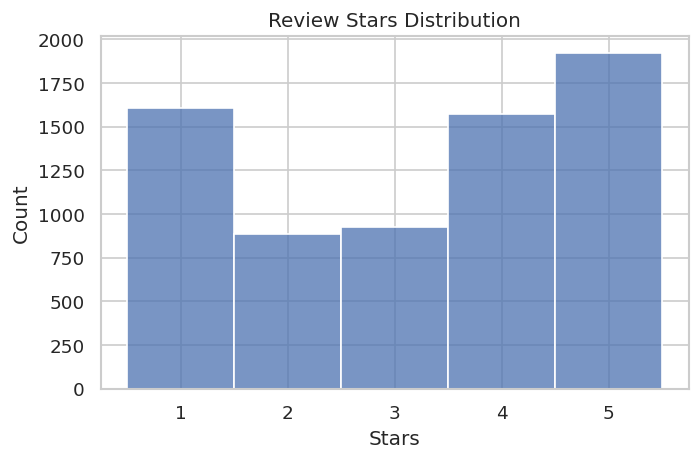

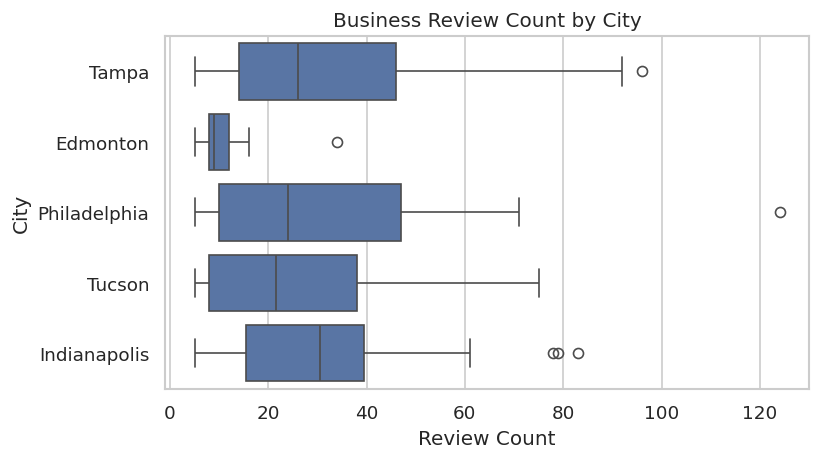

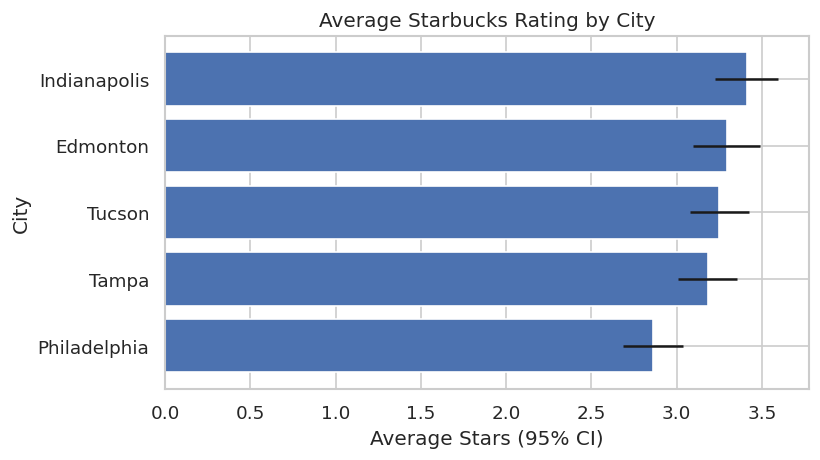

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

# 1) Review stars distribution
plt.figure(figsize=(6,4))
sns.histplot(rev["stars"], bins=5, discrete=True, color="#4c72b0")
plt.title("Review Stars Distribution")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Business review count by city
plt.figure(figsize=(7,4))
sns.boxplot(data=biz, x="review_count", y="city")
plt.title("Business Review Count by City")
plt.xlabel("Review Count")
plt.ylabel("City")
plt.tight_layout()
plt.show()

# 3) Average stars by city with 95% CI
summary = biz.groupby("city").agg(
    mean_stars=("stars", "mean"),
    std_stars=("stars", "std"),
    n=("stars", "count")
).reset_index()

summary["se"] = summary["std_stars"] / np.sqrt(summary["n"])
summary["ci95"] = 1.96 * summary["se"]
summary = summary.sort_values("mean_stars", ascending=False)

plt.figure(figsize=(7,4))
plt.barh(summary["city"], summary["mean_stars"], xerr=summary["ci95"], color="#4c72b0")
plt.xlabel("Average Stars (95% CI)")
plt.ylabel("City")
plt.title("Average Starbucks Rating by City")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()